In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import beta
from pathlib import Path
import networkx as nx

## Load the data

In [2]:
network_fp = 'test_data/cit-HepPh/orig/cit-HepPh_cleaned.tsv'
clustering_fp = 'test_data/cit-HepPh/orig/cit-HepPh_kaffpa_cc.tsv'

In [3]:
# Load edgelist
all_nodes = set()
neighbors = dict()
with open(network_fp, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for u, v in reader:
        neighbors.setdefault(u, set()).add(v)
        neighbors.setdefault(v, set()).add(u)
        all_nodes.add(u)
        all_nodes.add(v)

In [4]:
# Load clustering
all_clusters = set()
clustered_nodes = set()
node2cluster = dict()
cluster2nodes = dict()
with open(clustering_fp, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for v, c in reader:
        assert v in all_nodes
        assert v not in clustered_nodes
        node2cluster[v] = c
        cluster2nodes.setdefault(c, set()).add(v)
        clustered_nodes.add(v)
        all_clusters.add(c)

In [5]:
outlier_nodes = all_nodes - clustered_nodes

## Explore the data

In [6]:
# Compute number of edges between different clusters
edges_between_clusters = dict()
for u in neighbors:
    if u not in node2cluster:
        continue
    c1 = node2cluster[u]
    for v in neighbors[u]:
        if v not in node2cluster:
            continue
        c2 = node2cluster[v]
        if c1 == c2:
            continue
        if c1 > c2:
            c1, c2 = c2, c1
        edges_between_clusters.setdefault((c1, c2), 0)
        edges_between_clusters[(c1, c2)] += 1

# Compute total
total_edges = sum(edges_between_clusters.values()) // 2
print('Total edges:', total_edges)

# Compute number of edges within clusters
edges_within_clusters = dict()
for u in neighbors:
    if u not in node2cluster:
        continue
    c = node2cluster[u]
    for v in neighbors[u]:
        if v not in node2cluster:
            continue
        if node2cluster[v] != c:
            continue
        edges_within_clusters.setdefault(c, 0)
        edges_within_clusters[c] += 1

# Compute total
total_edges_within = sum(edges_within_clusters.values()) // 2
print('Total edges within clusters:', total_edges_within)

Total edges: 257807
Total edges within clusters: 200180


## Compute the mixing parameters

In [7]:
mixing_params = dict()
for v in clustered_nodes:
    assert v in neighbors
    c = node2cluster[v]
    neighbors_in_cluster = neighbors[v] & cluster2nodes[c]
    neighbors_out_cluster = neighbors[v] - neighbors_in_cluster
    mixing_params[v] = len(neighbors_out_cluster) / len(neighbors[v])

In [8]:
pi = sum([1 for v in mixing_params if mixing_params[v] == 0]) / len(mixing_params)
print('Fitted pi:', pi)

non_zero_mixing_params = [mixing_params[v] for v in mixing_params if mixing_params[v] > 0]
a, b, loc, scale = beta.fit(non_zero_mixing_params)
print('Fitted a, b, loc, scale:', a, b, loc, scale)

Fitted pi: 0.10851751616298301
Fitted a, b, loc, scale: 1.866512782004524 2.482304761708323 0.016010272295209613 0.9490610938553131


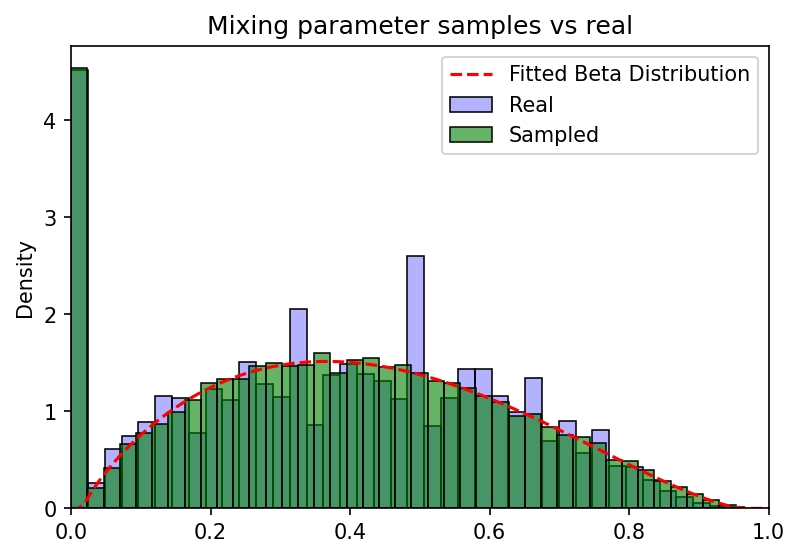

In [9]:
# Sample from the fitted distribution
n_samples = len(mixing_params)

samples = beta.rvs(a, b, loc, scale, size=n_samples)
samples[np.random.rand(n_samples) < pi] = 0.0

# Plot the samples overlayed on the real samples
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)

mixing_params_series = pd.Series([mixing_params[v] for v in mixing_params])
sns.histplot(mixing_params_series, ax=ax, stat='density', alpha=0.3, label='Real', color='blue')

sns.histplot(samples, ax=ax, stat='density', alpha=0.6, label='Sampled', color='green')

# Plot the fitted beta distribution
x = np.linspace(0, 1, 100)
y = (1 - pi) * beta.pdf(x, a, b, loc, scale)
ax.plot(x, y, 'r--', label='Fitted Beta Distribution')

ax.set_title('Mixing parameter samples vs real')
ax.set_xlim(0, 1)
ax.legend()
plt.show()

# Subnetwork stiching

In [10]:
syn_subnetworks_dir = Path('test_data/cit-HepPh/syn/subnetworks')

In [11]:
syn_subnetworks = dict()
syn_cluster_id2iid = dict()
syn_cluster_iid2id = dict()

for subnetwork_fp in syn_subnetworks_dir.iterdir():
    if subnetwork_fp.suffix != '.tsv':
        continue
    
    subnetwork_id = subnetwork_fp.stem
    subnetwork_iid = len(syn_subnetworks)
    syn_cluster_id2iid[subnetwork_id] = subnetwork_iid
    syn_cluster_iid2id[subnetwork_iid] = subnetwork_id

    with open(subnetwork_fp, 'r') as f:
        edges = [tuple(line.strip().split('\t')) for line in f]
    syn_subnetworks[subnetwork_iid] = edges

In [12]:
# Combine all the subnetworks into one networks, re-indexing the nodes
syn_nodes = list()
syn_node_id2iid = dict()
syn_node_iid2id = dict()

syn_edges = set()
syn_node2cluster = dict()
syn_cluster2nodes = dict()
syn_neighbors = dict()

for subnetwork_id, edges in syn_subnetworks.items():
    for u, v in edges:
        # Re-index the nodes
        u_id = f'{subnetwork_id}_{u}'
        v_id = f'{subnetwork_id}_{v}'

        if u_id not in syn_node_id2iid:
            syn_node_id2iid[u_id] = len(syn_nodes)
            syn_node_iid2id[syn_node_id2iid[u_id]] = u_id
            syn_nodes.append(u_id)
        if v_id not in syn_node_id2iid:
            syn_node_id2iid[v_id] = len(syn_nodes)
            syn_node_iid2id[syn_node_id2iid[v_id]] = v_id
            syn_nodes.append(v_id)

        u_iid = syn_node_id2iid[u_id]
        v_iid = syn_node_id2iid[v_id]

        syn_edges.add((u_iid, v_iid))

        # Add the nodes to the cluster
        syn_node2cluster[u_iid] = subnetwork_id
        syn_node2cluster[v_iid] = subnetwork_id
        syn_cluster2nodes.setdefault(subnetwork_id, set()).add(u_iid)
        syn_cluster2nodes.setdefault(subnetwork_id, set()).add(v_iid)

        # Add the neighbors
        syn_neighbors.setdefault(u_iid, set()).add(v_iid)
        syn_neighbors.setdefault(v_iid, set()).add(u_iid)

In [13]:
N = len(syn_nodes)

# Compute the degree of each node in the synthetic network
syn_external_degrees = np.zeros(N, dtype=int)

# Sample the mixing parameter for each node
mus = beta.rvs(a, b, loc, scale, size=N)
mus[np.random.rand(N) < pi] = 0.0

# Compute the mixing parameter for each node
for v, mu in zip(syn_nodes, samples):
    v_iid = syn_node_id2iid[v]
    c = syn_node2cluster[v_iid]
    int_degree = len(syn_neighbors[v_iid] & syn_cluster2nodes[c])
    syn_external_degrees[v_iid] = int(mu * int_degree / (1 - mu))

# Reduce the largest degree until the sequence is realizable
while not nx.is_graphical(syn_external_degrees):
    max_deg = np.max(syn_external_degrees)
    max_deg_idx = np.argmax(syn_external_degrees)
    syn_external_degrees[max_deg_idx] -= 1

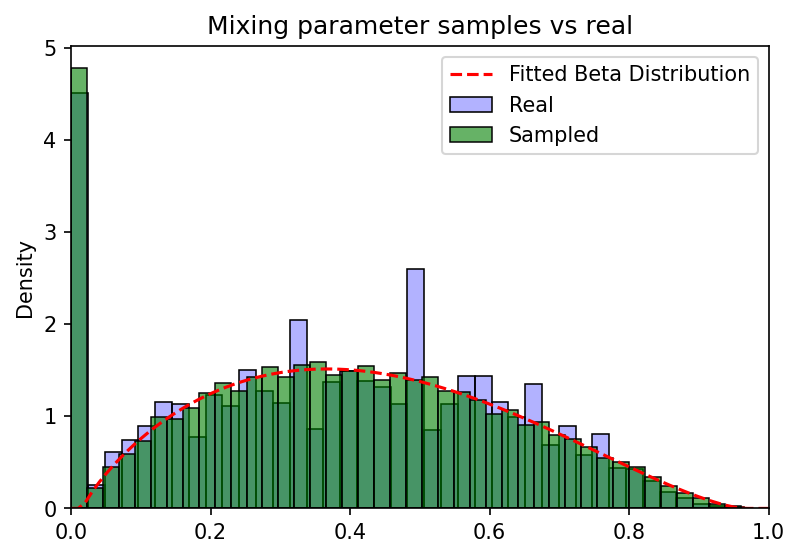

In [14]:
# Sample from the fitted distribution
# Plot the samples overlayed on the real samples
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)

mixing_params_series = pd.Series([mixing_params[v] for v in mixing_params])
sns.histplot(mixing_params_series, ax=ax, stat='density', alpha=0.3, label='Real', color='blue')

sns.histplot(mus, ax=ax, stat='density', alpha=0.6, label='Sampled', color='green')

# Plot the fitted beta distribution
x = np.linspace(0, 1, 100)
y = (1 - pi) * beta.pdf(x, a, b, loc, scale)
ax.plot(x, y, 'r--', label='Fitted Beta Distribution')

ax.set_title('Mixing parameter samples vs real')
ax.set_xlim(0, 1)
ax.legend()
plt.show()

In [15]:
# Generate a synthetic network with syn_external_degrees using networkx
G = nx.configuration_model(syn_external_degrees)

# Remove edge between nodes in the same cluster in G
for v in syn_nodes:
    v_iid = syn_node_id2iid[v]
    c = syn_node2cluster[v_iid]
    for u_iid in syn_cluster2nodes[c]:
        if G.has_edge(u_iid, v_iid):
            G.remove_edge(u_iid, v_iid)

# Turn the multigraph into a simple graph
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# Add back the edges
G.add_edges_from(syn_edges)

# Save the edgelist
syn_network_fp = 'test_data/cit-HepPh/syn/network.tsv'
with open(syn_network_fp, 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for u, v in G.edges:
        writer.writerow([u, v])

# Save the clustering
syn_clustering_fp = 'test_data/cit-HepPh/syn/clustering.tsv'
with open(syn_clustering_fp, 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for v in syn_nodes:
        writer.writerow([syn_node_id2iid[v], syn_node2cluster[syn_node_id2iid[v]]])